<a href="https://colab.research.google.com/github/intel-analytics/BigDL/blob/main/python/nano/notebooks/hpo/custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

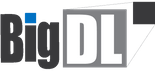

# Introduction
In this notebook we demonstrates how to use Nano HPO to tune the hyperparameters in tensorflow training. The model is built by subclassing tensorflow.keras.Model.


# Step0: Prepare Environment
You can install the latest pre-release version with nano support using below commands.

We recommend to run below commands, especially `source bigdl-nano-init` before jupyter kernel is started, or some of the optimizations may not take effect.

In [ ]:
# Install latest pre-release version of bigdl-nano
!pip install --pre bigdl-nano[tensorflow]
!pip install setuptools==58.0.4
!pip install protobuf==3.20.1
!source bigdl-nano-init

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
conda dir found: /usr/local/bin/..
OpenMP library found...
Setting OMP_NUM_THREADS...
Setting OMP_NUM_THREADS specified for pytorch...
Setting KMP_AFFINITY...
Setting KMP_BLOCKTIME...
Setting MALLOC_CONF...
Not in a conda env
+++++ Env Variables +++++
LD_PRELOAD=/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4
MALLOC_CONF=
OMP_NUM_THREADS=1
KMP_AFFINITY=granularity=fine,compact,1,0
KMP_BLOCKTIME=1
TF_ENABLE_ONEDNN_OPTS=1
ENABLE_TF_OPTS=1
NANO_TF_INTER_OP=1
+++++++++++++++++++++++++
Complete.


In [ ]:
# Install other dependecies for Nano HPO
!pip install ConfigSpace
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 209 kB 15.7 MB/s 
     |████████████████████████████████| 81 kB 8.4 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
     |████████████████████████████████| 146 kB 39.7 MB/s 
     |████████████████████████████████| 112 kB 41.2 MB/s 
     |████████████████████████████████| 49 kB 3.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=0a54c6970643d24a9797d28c73e10b1865935286e27caf04e9aec71f751622fb
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


# Step1: Init Nano AutoML
We need to enable Nano HPO before we use it for tensorflow training.

In [ ]:
import bigdl.nano.automl as automl
import bigdl.nano.automl.hpo as hpo
automl.hpo_config.enable_hpo_tf()

/usr/local/lib/python3.7/dist-packages/bigdl/nano/tf/__init__.py:24: UserWarning: NANO_TF_INTER_OP not found the in os.environ, please run `source bigdl-nano-init`
  warnings.warn("NANO_TF_INTER_OP not found the in os.environ, "
/usr/local/lib/python3.7/dist-packages/bigdl/nano/tf/__init__.py:30: UserWarning: OMP_NUM_THREADS not found the in os.environ, please run `source bigdl-nano-init`
  warnings.warn("OMP_NUM_THREADS not found the in os.environ, "


# Step2: Prepare data
We use fashion MNIST dataset for demonstration.

In [ ]:
from tensorflow import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

CLASSES = 10

img_x, img_y = x_train.shape[1], x_train.shape[2]
x_train = x_train.reshape(-1, img_x, img_y,1).astype("float32") / 255
x_test = x_test.reshape(-1, img_x, img_y,1).astype("float32") / 255

4431872/4422102 [==============================] - 0s 0us/step


# Step3: Build model and specify search spaces
We now create our model. 

Decorate the model class with hpo.tfmodel, and you will be able to specify search spaces in init arguments when creating the model, as shown below. For more details, refer to [user doc](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html).


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [ ]:
import tensorflow as tf
@hpo.tfmodel()
class MyModel(tf.keras.Model):

    def __init__(self, filters, kernel_size, strides, activation):
        super().__init__()
        self.conv1 = Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            activation=activation)
        self.pool1 = MaxPooling2D(pool_size=2)
        self.drop1 = Dropout(0.3)
        self.flat = Flatten()
        self.dense1 = Dense(256, activation='relu')
        self.drop3 = Dropout(0.5)
        self.dense2 = Dense(CLASSES, activation="softmax")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.drop1(x)
        x = self.flat(x)
        x = self.dense1(x)
        x = self.drop3(x)
        x = self.dense2(x)
        return x
model = MyModel(
    filters=hpo.space.Categorical(32, 64),
    kernel_size=hpo.space.Categorical(2, 4),
    strides=hpo.space.Categorical(1, 2),
    activation=hpo.space.Categorical("relu", "linear")
)

# Step4: Compile model
We now compile our model with loss function, optimizer and metrics. If you want to tune learning rate and batch size, refer to [user guide](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html#search-the-learning-rate).

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=RMSprop(learning_rate=0.001),
    metrics=["accuracy"],
)

# Step5: Run hyperparameter search
Run hyperparameter search by calling `model.search`. Set the `target_metric` and `direction` so that HPO optimizes the `target_metric` in the specified `direction`. Each trial will use a different set of hyperparameters in the search space range. Use `n_parallels` to set the nubmer of parallel processes to run trials. After search completes, you can use `search_summary` to retrive the search results for analysis. For more details, refer to [user doc](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html).

In [ ]:
%%time
from bigdl.nano.automl.hpo.backend import PrunerType
model.search(
    n_trials=5,
    target_metric='val_accuracy',
    direction="maximize",
    pruner=PrunerType.HyperBand,
    pruner_kwargs={'min_resource':1, 'max_resource':100, 'reduction_factor':3},
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    validation_split=0.2,
    verbose=False,
)

[I 2022-06-14 07:51:36,119] A new study created in memory with name: no-name-0cbf0f2d-5fc7-4245-b792-924ec2e250b3


Starting a new tuning
Epoch 1/5
375/375 - 8s - loss: 0.6107 - accuracy: 0.7830 - val_loss: 0.4149 - val_accuracy: 0.8488 - 8s/epoch - 21ms/step
Epoch 2/5
375/375 - 7s - loss: 0.4329 - accuracy: 0.8438 - val_loss: 0.3630 - val_accuracy: 0.8681 - 7s/epoch - 20ms/step
Epoch 3/5
375/375 - 7s - loss: 0.3931 - accuracy: 0.8575 - val_loss: 0.3471 - val_accuracy: 0.8729 - 7s/epoch - 19ms/step
Epoch 4/5
375/375 - 7s - loss: 0.3746 - accuracy: 0.8635 - val_loss: 0.3524 - val_accuracy: 0.8694 - 7s/epoch - 20ms/step
Epoch 5/5
375/375 - 7s - loss: 0.3621 - accuracy: 0.8695 - val_loss: 0.3197 - val_accuracy: 0.8828 - 7s/epoch - 20ms/step


[I 2022-06-14 07:52:13,425] Trial 0 finished with value: 0.8828333616256714 and parameters: {'activation▁choice': 1, 'filters▁choice': 0, 'kernel_size▁choice': 0, 'strides▁choice': 1}. Best is trial 0 with value: 0.8828333616256714.


Epoch 1/5
375/375 - 20s - loss: 0.5215 - accuracy: 0.8151 - val_loss: 0.3636 - val_accuracy: 0.8669 - 20s/epoch - 54ms/step
Epoch 2/5
375/375 - 19s - loss: 0.3665 - accuracy: 0.8678 - val_loss: 0.3334 - val_accuracy: 0.8804 - 19s/epoch - 51ms/step
Epoch 3/5
375/375 - 21s - loss: 0.3218 - accuracy: 0.8844 - val_loss: 0.3105 - val_accuracy: 0.8883 - 21s/epoch - 56ms/step
Epoch 4/5
375/375 - 20s - loss: 0.2968 - accuracy: 0.8934 - val_loss: 0.2860 - val_accuracy: 0.8981 - 20s/epoch - 53ms/step
Epoch 5/5
375/375 - 20s - loss: 0.2775 - accuracy: 0.9004 - val_loss: 0.2837 - val_accuracy: 0.8985 - 20s/epoch - 52ms/step


[I 2022-06-14 07:54:35,924] Trial 1 finished with value: 0.8985000252723694 and parameters: {'activation▁choice': 1, 'filters▁choice': 0, 'kernel_size▁choice': 1, 'strides▁choice': 0}. Best is trial 1 with value: 0.8985000252723694.


Epoch 1/5
375/375 - 48s - loss: 0.5305 - accuracy: 0.8119 - val_loss: 0.3556 - val_accuracy: 0.8729 - 48s/epoch - 129ms/step
Epoch 2/5
375/375 - 47s - loss: 0.3542 - accuracy: 0.8737 - val_loss: 0.3045 - val_accuracy: 0.8907 - 47s/epoch - 126ms/step
Epoch 3/5
375/375 - 46s - loss: 0.3124 - accuracy: 0.8877 - val_loss: 0.3179 - val_accuracy: 0.8847 - 46s/epoch - 124ms/step
Epoch 4/5
375/375 - 49s - loss: 0.2881 - accuracy: 0.8961 - val_loss: 0.2718 - val_accuracy: 0.9040 - 49s/epoch - 131ms/step
Epoch 5/5
375/375 - 49s - loss: 0.2751 - accuracy: 0.9022 - val_loss: 0.2714 - val_accuracy: 0.9026 - 49s/epoch - 130ms/step


[I 2022-06-14 07:58:58,425] Trial 2 finished with value: 0.9039999842643738 and parameters: {'activation▁choice': 0, 'filters▁choice': 1, 'kernel_size▁choice': 0, 'strides▁choice': 0}. Best is trial 2 with value: 0.9039999842643738.


Epoch 1/5
375/375 - 8s - loss: 0.6889 - accuracy: 0.7514 - val_loss: 0.4607 - val_accuracy: 0.8334 - 8s/epoch - 22ms/step
Epoch 2/5
375/375 - 8s - loss: 0.4777 - accuracy: 0.8277 - val_loss: 0.4082 - val_accuracy: 0.8466 - 8s/epoch - 21ms/step
Epoch 3/5
375/375 - 8s - loss: 0.4279 - accuracy: 0.8452 - val_loss: 0.3585 - val_accuracy: 0.8677 - 8s/epoch - 21ms/step
Epoch 4/5
375/375 - 8s - loss: 0.3988 - accuracy: 0.8556 - val_loss: 0.3470 - val_accuracy: 0.8720 - 8s/epoch - 22ms/step
Epoch 5/5
375/375 - 8s - loss: 0.3828 - accuracy: 0.8623 - val_loss: 0.3363 - val_accuracy: 0.8742 - 8s/epoch - 23ms/step


[I 2022-06-14 07:59:39,921] Trial 3 finished with value: 0.8741666674613953 and parameters: {'activation▁choice': 0, 'filters▁choice': 0, 'kernel_size▁choice': 0, 'strides▁choice': 1}. Best is trial 2 with value: 0.9039999842643738.


Epoch 1/5
375/375 - 7s - loss: 0.6287 - accuracy: 0.7717 - val_loss: 0.4239 - val_accuracy: 0.8471 - 7s/epoch - 18ms/step
Epoch 2/5
375/375 - 6s - loss: 0.4369 - accuracy: 0.8427 - val_loss: 0.3693 - val_accuracy: 0.8633 - 6s/epoch - 17ms/step
Epoch 3/5
375/375 - 6s - loss: 0.3940 - accuracy: 0.8570 - val_loss: 0.3435 - val_accuracy: 0.8772 - 6s/epoch - 16ms/step
Epoch 4/5


[I 2022-06-14 08:00:05,357] Trial 4 pruned. Trial was pruned at epoch 3.


CPU times: user 10min 38s, sys: 3min 45s, total: 14min 23s
Wall time: 8min 29s


In [ ]:
print(model.search_summary())

Number of finished trials: 5
Best trial:
  Value: 0.9039999842643738
  Params: 
    activation▁choice: 0
    filters▁choice: 1
    kernel_size▁choice: 0
    strides▁choice: 0


In [ ]:
study = model.search_summary()
study.trials_dataframe(attrs=("number", "value", "params", "state"))

Number of finished trials: 5
Best trial:
  Value: 0.9039999842643738
  Params: 
    activation▁choice: 0
    filters▁choice: 1
    kernel_size▁choice: 0
    strides▁choice: 0


,number,value,params_activation▁choice,params_filters▁choice,params_kernel_size▁choice,params_strides▁choice,state
0,0,0.882833,1,0,0,1,COMPLETE
1,1,0.898500,1,0,1,0,COMPLETE
2,2,0.904000,0,1,0,0,COMPLETE
3,3,0.874167,0,0,0,1,COMPLETE
4,4,0.876833,1,0,1,1,PRUNED


# Step 6: fit with the best hyperparameters
After search, `model.fit` will autotmatically use the best hyperparmeters found in search to fit the model.

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=128, epochs=5, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/5
375/375 [==============================] - 53s 140ms/step - loss: 0.5348 - accuracy: 0.8099 - val_loss: 0.3566 - val_accuracy: 0.8759
Epoch 2/5
375/375 [==============================] - 51s 136ms/step - loss: 0.3535 - accuracy: 0.8741 - val_loss: 0.3114 - val_accuracy: 0.8878
Epoch 3/5
375/375 [==============================] - 51s 137ms/step - loss: 0.3144 - accuracy: 0.8880 - val_loss: 0.2905 - val_accuracy: 0.8950
Epoch 4/5
375/375 [==============================] - 53s 140ms/step - loss: 0.2916 - accuracy: 0.8949 - val_loss: 0.2910 - val_accuracy: 0.8966
Epoch 5/5
375/375 [==============================] - 52s 138ms/step - loss: 0.2762 - accuracy: 0.9020 - val_loss: 0.2787 - val_accuracy: 0.8998
313/313 - 3s - loss: 0.2913 - accuracy: 0.8927 - 3s/epoch - 8ms/step
Test loss: 0.2913445234298706
Test accuracy: 0.8927000164985657


Check out the summary of the model. The model has already been built with the best hyperparameters found by nano hpo.

In [ ]:
print(model.summary())

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           multiple                  320       
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  2769152   
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                        